## Project PD2

### import packages

In [1]:
import datascience as ds
from datascience import *
import numpy as np
from collections import Counter
from graphviz import Source
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.externals import joblib
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### tweets data loaded into Jupyter Notebook as Table object

In [2]:
df1 = ds.Table.read_table('Climate1SupportiveLevel.csv', sep=',')
df2 = ds.Table.read_table('ClimateBalancedDS2.csv', sep=',')
df = df1.append(df2)
# df = ds.Table.read_table('MergedLabelledData.csv', sep=',')
test_index = np.random.choice(df.num_rows, 100, replace=False)
train_val_index = [i for i in np.arange(df.num_rows) if i not in test_index]
test_data = df.take[test_index]
df = df.take[train_val_index]
X = list(df['Text'])
y = list(df['Support'])
test_X = list(test_data['Text'])
test_y = list(test_data['Support'])

### A description of all model enhancements incorporated into the construction of PD2.






#### used parameters

- CountVector
    - token_pattern = "(?!RT|rt|\d+)[@#]*[\w\'_-]{2,100}"
    - analyzer = 'word'
    - stop_words = the top 30 most common words in DS1+DS2 tweets 
    - min_df = 10
    - ngram_range=(1,2)
- DecisionTree
    - criterion='entropy'
    - max_depth = 10
    - min_samples_leaf = 2

### A description of all model parameters you tried and the associated Stratified k-fold cross validation results for each model parameter choice based on the combined data set (DS1 + DS2)

 - max_depth=range(1, 15)
 - stop_words:
     - default in CountVectorizer: 'english'
     - user_defined: ['a', 'an', 'the', 'it', 'is', 'are', 'be', 'of', 'this', 'that', 'RT', 'rt','https']
     - the top 30 most common words in DS1+DS2 tweets (chosen)
     
code and test results as follows:

### Check whether the data distribution is balanced

In [3]:
def check(sentiment, index, note='training'):
    if sentiment==0:
        label = 'not supportive'
    else:
        label = 'supportive'
    print('There are {} '.format(df.take(index).where('Support', 
          are.equal_to(sentiment)).size[0][0])+label+' tweets in the '+note+' set.')

#### Model Building

In [4]:
def custom_split(train_index, test_index):
    trainingset = df.take(train_index)
    testingset = df.take(test_index)    
        
    X_train= list(trainingset['Text'])
    y_train= list(trainingset['Support'])
    X_test= list(testingset['Text'])
    y_test= list(testingset['Support'])
    
    return X_train, X_test, y_train, y_test

### classifier

In [6]:
def classifier(X_train, y_train, X_test, fold, max_depth, min_samples_leaf, stop_words, overfit_risk=False):
    # token_pattern='(([#@]|[0-9]|[a-z]|[A-Z])+)'
    clf = Pipeline(
        [
            ('vect', CountVectorizer(token_pattern="(?!RT|rt|\d+)[@#]*[\w\'_-]{2,100}",
                                     analyzer = 'char',
                                     stop_words = stop_words,
                                     min_df = 10,
                                     ngram_range=(1,2))),
            ('clf', DecisionTreeClassifier(criterion='entropy',
                                           random_state = 100,
                                           max_depth = max_depth,
                                           min_samples_leaf = min_samples_leaf))
        ])
    clf.fit(X_train, y_train)
    feature_names = clf.named_steps['vect'].get_feature_names()
    try:
        dot_data = tree.export_graphviz(clf.named_steps['clf'], out_file=None, 
                                        feature_names=feature_names)
        graph = Source(dot_data)
        graph.render('ClimateClassifier-Fold_{}'.format(fold))
    except Exception as e:
        print(e)
    predicted_y_train = clf.predict(X_train)
    predicted_y_test = clf.predict(X_test)
    # save as pickle
    if overfit_risk:
        joblib.dump(clf, 'ClimateTeam7PD2_maxdepth{}.pkl'.format(max_depth))
    else:
        joblib.dump(clf, 'ClimateTeam7PD2D.pkl')
    return predicted_y_train, predicted_y_test

### evaluation

In [7]:
def eval_results(predicted_y_train, y_train, predicted_y_test, y_test, fold):
    accuracy_s = accuracy_score(y_test, predicted_y_test)
    precision_s = precision_score(y_test, predicted_y_test)
    recall_s = recall_score(y_test, predicted_y_test)
    f1_s = f1_score(y_test, predicted_y_test)
    cm_train = confusion_matrix(y_train, predicted_y_train)
    cm_test = confusion_matrix(y_test, predicted_y_test)  
    
    print('Accuracy Score:', accuracy_s)
    print("Precision Score:", precision_s)
    print("Recall Score:", recall_s)
    print("f1 Score:", f1_s)
    print('confusion_matrix of training set is: \n', cm_train, '\n')
    print('confusion_matrix of testing set is: \n', cm_test, '\n')
    print(classification_report(y_test, predicted_y_test))
    
    classes = ['not supportive', 'supportive']
    plt.subplot(2, 5, fold)
    sns.heatmap(cm_train, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('Fold {}: confusion matrix of training set'.format(fold))
    plt.subplot(2, 5, fold+5)
    sns.heatmap(cm_test, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('Fold {}: confusion matrix of testing set'.format(fold))
    return accuracy_s, precision_s, recall_s, f1_s

### k-fold

In [8]:
def k_fold_evaluate(X, y, max_depth, min_samples_leaf, stop_words, print_eval=True, overfit_risk=False):
    # initialization
    accuracy = []
    precision = []
    recall=[]
    f1 = []
    fold = 1
    skf = StratifiedKFold(n_splits=5, random_state=100, shuffle= True)
    
    # build model and collect results
    for val_index, test_index in skf.split(X, y):
        X_train, X_val, y_train, y_val = custom_split(val_index, test_index)
        
        predicted_y_train, predicted_y_val = classifier(X_train=X_train, y_train=y_train, 
                                                          X_test=X_val, fold=fold,
                                                          max_depth = max_depth,
                                                          min_samples_leaf = min_samples_leaf,
                                                          stop_words = stop_words,
                                                          overfit_risk=overfit_risk)
        metrics_df={}
        if print_eval:
            print('\nFold: {}'.format(fold))
            accuracy_s, precision_s, recall_s, f1_s = eval_results(predicted_y_train, y_train, predicted_y_val, y_val, fold)

            accuracy.append(accuracy_s)
            precision.append(precision_s)
            recall.append(recall_s)
            f1.append(f1_s)

            metrics_df = pd.DataFrame(
                        {
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall':recall,
                            'f1':f1
                        }
                    )
            fold += 1
    return metrics_df

### Tests: max_depth : 1-15

In [9]:
df1 = ds.Table.read_table('Climate1SupportiveLevel.csv', sep=',')
df2 = ds.Table.read_table('ClimateBalancedDS2.csv', sep=',')
df = df1.append(df2)
test_index = np.random.choice(df.num_rows, 100, replace=False)
train_val_index = [i for i in np.arange(df.num_rows) if i not in test_index]
test_data = df.take[test_index]
df = df.take[train_val_index]
X = list(df['Text'])
y = list(df['Support'])
test_X = list(test_data['Text'])
test_y = list(test_data['Support'])

#### test1: stop-words: default

In [10]:
f1_lst_test1 = []
f1_lst_train1 = []
for d in range(1, 16):
    k_fold_evaluate(X, y, max_depth=d, min_samples_leaf=10, stop_words='english', print_eval=False, overfit_risk=True)
    clf_tmp = joblib.load('ClimateTeam7PD2_maxdepth{}.pkl'.format(d))
    print('maxdepth=', d)
    # test
    y_pred = clf_tmp.predict(test_X)
    print('test f1')
    print(f1_score(y_pred=y_pred, y_true=test_y))
    f1_lst_test1.append(f1_score(y_pred=y_pred, y_true=test_y))
    # train_val
    y_pred = clf_tmp.predict(X)
    print('train f1')
    print(f1_score(y_pred=y_pred, y_true=y))
    f1_lst_train1.append(f1_score(y_pred=y_pred, y_true=y))

maxdepth= 1
test f1
0.6774193548387096
train f1
0.7136929460580913
maxdepth= 2
test f1
0.6774193548387096
train f1
0.7136929460580913
maxdepth= 3
test f1
0.6774193548387096
train f1
0.7136929460580913
maxdepth= 4
test f1
0.6422018348623854
train f1
0.6777476255088195
maxdepth= 5
test f1
0.6666666666666667
train f1
0.719303699098539
maxdepth= 6
test f1
0.7017543859649124
train f1
0.7271004421983576
maxdepth= 7
test f1
0.6486486486486486
train f1
0.7318652849740933
maxdepth= 8
test f1
0.6727272727272728
train f1
0.7382198952879582
maxdepth= 9
test f1
0.6415094339622641
train f1
0.7543571193686286


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(1,16), f1_lst_test1, label='f1 of testset')
plt.plot(np.arange(1,16), f1_lst_train1, label='f1 of trainset')
plt.xlabel('max_depth')
plt.title('Double check the overfitting risk')
plt.legend(loc='lower right')
plt.show()

#### test2: stop_words: ['a', 'an', 'the', 'it', 'is', 'are', 'be', 'of', 'this', 'that', 'RT', 'rt','https']

In [140]:
f1_lst_test2 = []
f1_lst_train2 = []
for d in range(1, 16):
    k_fold_evaluate(X, y, max_depth=d, min_samples_leaf=10, 
                    stop_words=['a', 'an', 'the', 'it', 'is', 'are', 'be', 'of', 'this', 'that', 'RT', 'rt','https'], 
                    print_eval=False, overfit_risk=True)
    clf_tmp = joblib.load('ClimateTeam7PD2_maxdepth{}.pkl'.format(d))
    print('maxdepth=', d)
    # test
    y_pred = clf_tmp.predict(test_X)
    print('test f1')
    print(f1_score(y_pred=y_pred, y_true=test_y))
    f1_lst_test2.append(f1_score(y_pred=y_pred, y_true=test_y))
    # train_val
    y_pred = clf_tmp.predict(X)
    print('train f1')
    print(f1_score(y_pred=y_pred, y_true=y))
    f1_lst_train2.append(f1_score(y_pred=y_pred, y_true=y))

maxdepth= 1
test f1
0.6495726495726496
train f1
0.8917987594762233
maxdepth= 2
test f1
0.6782608695652174
train f1
0.8868778280542987
maxdepth= 3
test f1
0.5871559633027523
train f1
0.8881900768693222
maxdepth= 4
test f1
0.6017699115044247
train f1
0.8839471855455177
maxdepth= 5
test f1
0.6545454545454547
train f1
0.8868715083798884
maxdepth= 6
test f1
0.6140350877192983
train f1
0.8840277777777779
maxdepth= 7
test f1
0.5688073394495414
train f1
0.8876598686484618
maxdepth= 8
test f1
0.6206896551724138
train f1
0.8934707903780069
maxdepth= 9
test f1
0.6379310344827587
train f1
0.8901174844505875
maxdepth= 10
test f1
0.603448275862069
train f1
0.8864902506963787
maxdepth= 11
test f1
0.6434782608695652
train f1
0.8859527121001392
maxdepth= 12
test f1
0.6238532110091742
train f1
0.8838977194194887
maxdepth= 13
test f1
0.6491228070175439
train f1
0.8858035404373481
maxdepth= 14
test f1
0.6548672566371682
train f1
0.8951919750951227
maxdepth= 15
test f1
0.6491228070175439
train f1
0.8886554

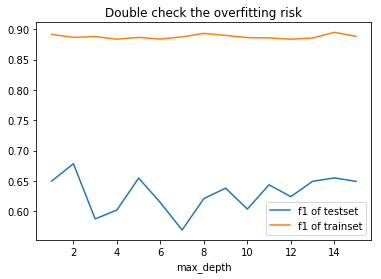

In [141]:
plt.plot(np.arange(1,16), f1_lst_test2, label='f1 of testset')
plt.plot(np.arange(1,16), f1_lst_train2, label='f1 of trainset')
plt.xlabel('max_depth')
plt.title('Double check the overfitting risk')
plt.legend(loc='lower right')
plt.show()

#### test3: stop_words: most common words in DS1+DS2 tweets

In [142]:
stop_w = [i[0] for i in Counter([word for sentence in X for word in sentence.split() 
                                 if 'climate' not in word.lower() and 'change' not in word.lower()
                                 and word.isalpha() 
                                 and len(word)>1]).most_common()[:30]]
stop_w

['the',
 'to',
 'RT',
 'of',
 'is',
 'and',
 'in',
 'that',
 'on',
 'for',
 'are',
 'you',
 'we',
 'The',
 'it',
 'this',
 'about',
 'be',
 'by',
 'have',
 'not',
 'will',
 'our',
 'from',
 'as',
 'can',
 'with',
 'all',
 'We',
 'do']

In [143]:
f1_lst_test3 = []
f1_lst_train3 = []
for d in range(1, 16):
    k_fold_evaluate(X, y, max_depth=d, min_samples_leaf=10, 
                    stop_words=stop_w, 
                    print_eval=False, overfit_risk=True)
    clf_tmp = joblib.load('ClimateTeam7PD2_maxdepth{}.pkl'.format(d))
    print('maxdepth=', d)
    # test
    y_pred = clf_tmp.predict(test_X)
    print('test f1')
    print(f1_score(y_pred=y_pred, y_true=test_y))
    f1_lst_test3.append(f1_score(y_pred=y_pred, y_true=test_y))
    # train_val
    y_pred = clf_tmp.predict(X)
    print('train f1')
    print(f1_score(y_pred=y_pred, y_true=y))
    f1_lst_train3.append(f1_score(y_pred=y_pred, y_true=y))

maxdepth= 1
test f1
0.5945945945945946
train f1
0.8881143255489717
maxdepth= 2
test f1
0.6428571428571429
train f1
0.8853948287910552
maxdepth= 3
test f1
0.6218487394957983
train f1
0.8889667250437829
maxdepth= 4
test f1
0.5840707964601771
train f1
0.8840630472854641
maxdepth= 5
test f1
0.603448275862069
train f1
0.8856345885634588
maxdepth= 6
test f1
0.6495726495726496
train f1
0.8876521739130434
maxdepth= 7
test f1
0.6324786324786326
train f1
0.8868778280542987
maxdepth= 8
test f1
0.6545454545454547
train f1
0.886512590548465
maxdepth= 9
test f1
0.6486486486486486
train f1
0.8899789768745621
maxdepth= 10
test f1
0.6486486486486486
train f1
0.8799157303370787
maxdepth= 11
test f1
0.6181818181818183
train f1
0.8866268866268867
maxdepth= 12
test f1
0.5765765765765766
train f1
0.8842917251051894
maxdepth= 13
test f1
0.5871559633027523
train f1
0.8818565400843882
maxdepth= 14
test f1
0.6194690265486726
train f1
0.8928199791883455
maxdepth= 15
test f1
0.6371681415929203
train f1
0.88594349

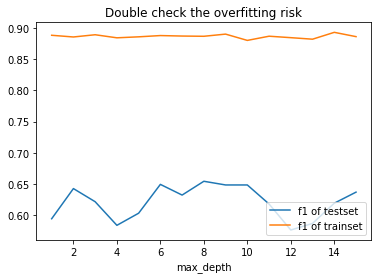

In [144]:
plt.plot(np.arange(1,16), f1_lst_test3, label='f1 of testset')
plt.plot(np.arange(1,16), f1_lst_train3, label='f1 of trainset')
plt.xlabel('max_depth')
plt.title('Double check the overfitting risk')
plt.legend(loc='lower right')
plt.show()

## Final result


Fold: 1
Accuracy Score: 0.6272401433691757
Precision Score: 0.65
Recall Score: 0.6232876712328768
f1 Score: 0.6363636363636365
confusion_matrix of training set is: 
 [[1008   53]
 [  88 1076]] 

confusion_matrix of testing set is: 
 [[168  98]
 [110 182]] 

             precision    recall  f1-score   support

          0       0.60      0.63      0.62       266
          1       0.65      0.62      0.64       292

avg / total       0.63      0.63      0.63       558


Fold: 2
Accuracy Score: 0.6014362657091562
Precision Score: 0.6254545454545455
Recall Score: 0.5910652920962199
f1 Score: 0.607773851590106
confusion_matrix of training set is: 
 [[ 985   76]
 [  70 1095]] 

confusion_matrix of testing set is: 
 [[163 103]
 [119 172]] 

             precision    recall  f1-score   support

          0       0.58      0.61      0.59       266
          1       0.63      0.59      0.61       291

avg / total       0.60      0.60      0.60       557


Fold: 3
Accuracy Score: 0.600719424460

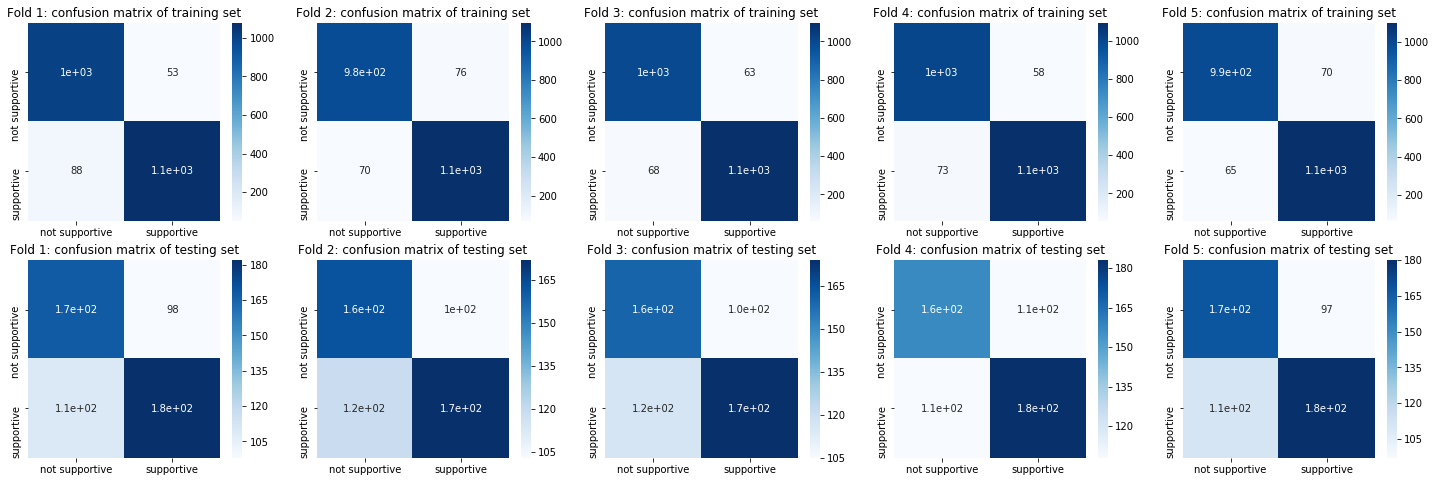

In [145]:
plt.figure(figsize=(25, 8))
metrics_df = k_fold_evaluate(X, y, max_depth=10, min_samples_leaf=10, 
                    stop_words='english', 
                    print_eval=True, overfit_risk=False)
plt.show()

In [146]:
metrics_df

,accuracy,precision,recall,f1
0,0.627240,0.650000,0.623288,0.636364
1,0.601436,0.625455,0.591065,0.607774
2,0.600719,0.623656,0.597938,0.610526
3,0.611511,0.628866,0.628866,0.628866
4,0.625899,0.649819,0.618557,0.633803


In [147]:
clf2 = joblib.load('ClimateTeam7PD2C.pkl')

In [148]:
df = ds.Table.read_table('ClimateEntireTweetOnlyDS3.csv')
X = list(df['Text'])
y_pred = clf2.predict(X)

In [149]:
len(y_pred[y_pred==1])

1134

In [150]:
y_pred = pd.DataFrame(y_pred)
tmp = pd.concat([pd.read_csv('ClimateEntireTweetOnlyDS3.csv').Text, y_pred], axis=1)
tmp.columns = ['Text', 'PredictedStance']
tmp.to_csv('ClimateTeam7PDmodelCprediction.csv', index=None)